In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest, mannwhitneyu, ttest_ind
from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import load_results

import copy
# general EMA imports 
from ema_workbench import (save_results, load_results, ema_logging, perform_experiments)
from ema_workbench import (Samplers, Model, Policy, Scenario, 
                            MultiprocessingEvaluator, SequentialEvaluator,
                            ScalarOutcome, Constant, optimize,
                            RealParameter, IntegerParameter, CategoricalParameter)
from ema_workbench.em_framework.samplers import sample_uncertainties, sample_levers

# sensitivity analysis
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
# PRIM
from ema_workbench.analysis import prim
# dimensional stacking (visualization tool for sensitivity analysis)
from ema_workbench.analysis import dimensional_stacking
# SOBOL
from SALib.analyze import sobol
#from ema_workbench.em_framework.evaluators import SOBOL

# feature scoring 
from ema_workbench.analysis import feature_scoring

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [5]:
#choose problem formulation number, between 0-5
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(1)

In [6]:
# Set uncertainties and levers variables
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)

In [4]:
#running the model through EMA workbench
from ema_workbench import (MultiprocessingEvaluator, ema_logging,
                           perform_experiments, SequentialEvaluator)
ema_logging.log_to_stderr(ema_logging.INFO)
 
# Make use of the multiprocessing evaluator to save time
# running with 2000 scenarios
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=5000, policies=1)

# Save results for later analysis
from ema_workbench import save_results
save_results(results, './results/OpnExpl_5000_scenarios_1_random_policy_PF1.tar.gz')

[MainProcess/INFO] pool started with 1 workers
[MainProcess/INFO] performing 5000 scenarios * 1 policies * 1 model(s) = 5000 experiments
100%|████████████████████████████████████| 5000/5000 [1:00:26<00:00,  1.38it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to C:\Users\NKondhalkar\Documents\final assignment\results\OpnExpl_5000_scenarios_1_random_policy_PF1.tar.gz


In [4]:

# Load results that were previously generated
load_file_name ='./results/OpnExpl_5000_scenarios_1_random_policy_PF1.tar.gz'
results = load_results(load_file_name)

# See what the results look like and what outcomes were captured
experiments, outcomes = results
print(outcomes.keys())

# Create temporary dataframe containing experiments and outcomes
temp = experiments.copy(deep=True)
# outcomes
temp.head()

[MainProcess/INFO] results loaded successfully from C:\Users\NKondhalkar\Documents\final assignment\results\OpnExpl_5000_scenarios_1_random_policy_PF1.tar.gz


dict_keys(['Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths'])


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
0,56,34.914595,1.5,0.750249,219.578090,10.0,0.022020,116.971680,10.0,0.759828,...,7,7,8,9,8,8,3,1,0,dikesnet
1,57,158.675537,10.0,0.860753,245.259501,1.5,0.776723,57.318300,10.0,0.978816,...,7,7,8,9,8,8,3,2,0,dikesnet
2,18,30.061044,1.0,0.619163,326.720107,10.0,0.100802,136.823088,1.0,0.901101,...,7,7,8,9,8,8,3,3,0,dikesnet
3,11,200.601043,10.0,0.158893,86.695023,10.0,0.788640,342.461587,1.0,0.151082,...,7,7,8,9,8,8,3,4,0,dikesnet
4,130,153.494006,1.0,0.082358,192.857418,1.5,0.649949,127.498011,1.5,0.717488,...,7,7,8,9,8,8,3,5,0,dikesnet


In [5]:
experiments = temp.copy(deep=True)

# Drop the lever columns from the dataframe to make sure prim only focusses on uncertainties
experiments.drop(experiments.columns[19:], axis=1, inplace=True)
print(outcomes.keys())
experiments


dict_keys(['Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths'])


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
0,56,34.914595,1.5,0.750249,219.578090,10.0,0.022020,116.971680,10.0,0.759828,272.503046,1.5,0.925154,256.238984,10.0,0.755308,2.5,1.5,4.5
1,57,158.675537,10.0,0.860753,245.259501,1.5,0.776723,57.318300,10.0,0.978816,271.255074,10.0,0.593676,280.778544,1.0,0.222541,3.5,1.5,2.5
2,18,30.061044,1.0,0.619163,326.720107,10.0,0.100802,136.823088,1.0,0.901101,116.402879,10.0,0.513404,82.647563,1.0,0.744248,2.5,3.5,2.5
3,11,200.601043,10.0,0.158893,86.695023,10.0,0.788640,342.461587,1.0,0.151082,225.931889,1.0,0.594156,110.365869,10.0,0.646885,2.5,1.5,4.5
4,130,153.494006,1.0,0.082358,192.857418,1.5,0.649949,127.498011,1.5,0.717488,80.101564,1.0,0.120120,254.888258,1.5,0.921661,2.5,4.5,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,109,287.067955,1.5,0.069742,190.334104,1.5,0.144575,55.858092,1.5,0.919964,131.022378,1.0,0.117439,228.789609,1.5,0.731977,4.5,2.5,2.5
4996,47,121.491400,1.0,0.447407,244.812831,1.0,0.245249,241.048291,10.0,0.681114,270.468955,1.5,0.823516,328.052366,1.0,0.477156,3.5,1.5,1.5
4997,81,66.683566,1.0,0.890420,62.631754,10.0,0.863023,51.270358,1.5,0.334554,169.045181,1.0,0.247248,284.960625,1.0,0.512733,4.5,3.5,1.5
4998,78,163.874800,1.5,0.874385,77.882380,1.0,0.153442,174.352184,10.0,0.908649,218.343402,1.0,0.935837,222.589121,10.0,0.533478,3.5,4.5,4.5


In [6]:
# Prepare to do prim
from ema_workbench.analysis import prim

# Set the output to the category that we are interested in for this run
outcome_entry = outcomes["Expected Number of Deaths"]

x = experiments
# Set our output threshold to be the 90th percentile of all of those outputs
y_limit = np.quantile(outcome_entry,0.9)

# Only select outputs that are above this threshold
y = np.array([value > y_limit for value in outcome_entry])

# Conduct our prim analysis using a threshold of 0.8
prim_alg = prim.Prim(x, y, threshold=0.8)

# Get the box that prim found for us
box1 = prim_alg.find_box()

[MainProcess/INFO] 5000 points remaining, containing 500 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.0712, coverage: 0.712, density: 1.0 restricted_dimensions: 1


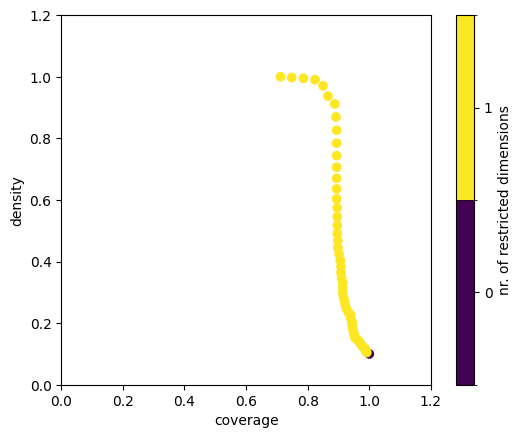

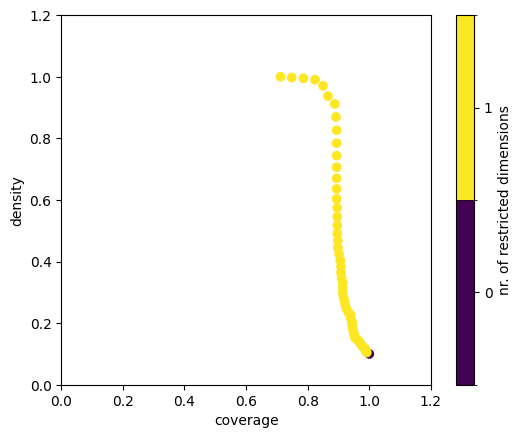

In [7]:
box1.show_tradeoff()


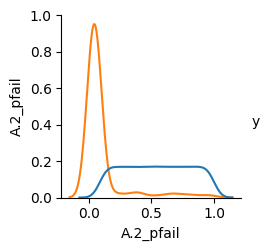

In [8]:
# Show scatter plots for this prim analysis
box1.show_pairs_scatter()
plt.show()

In [9]:

# Load results that were previously generated
experimentsNull, outcomesNull = load_results('./results/10000Scenarios_NoAction_PF6.tar.gz')
print(outcomesNull.keys())

# Create temporary dataframe containing experiments and outcomes
tempNull = experimentsNull.copy(deep=True)
# outcomes
tempNull.head()

[MainProcess/INFO] results loaded successfully from C:\Users\NKondhalkar\Documents\final assignment\results\10000Scenarios_NoAction_PF6.tar.gz


dict_keys(['A3 Expected Annual Damage', 'A3 Aggr Expected Number of Deaths', 'A3 Dike Investment Costs', 'Room for River Investment Costs', 'Evacuation Costs'])


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,A.4_DikeIncrease 0,A.5_DikeIncrease 0,scenario,policy,model
0,24,65.941257,1.5,0.233103,218.233392,10.0,0.929673,333.418849,1.5,0.108179,...,0,0,0,0,0,0,0,0,NoAction,dikesnet
1,64,193.661960,1.0,0.519617,321.858384,1.0,0.920300,316.318319,1.5,0.478983,...,0,0,0,0,0,0,0,1,NoAction,dikesnet
2,89,200.701544,10.0,0.034166,40.533440,1.5,0.542181,200.431481,10.0,0.223973,...,0,0,0,0,0,0,0,2,NoAction,dikesnet
3,58,246.821473,1.0,0.721832,116.340717,1.5,0.117992,267.786741,1.0,0.272988,...,0,0,0,0,0,0,0,3,NoAction,dikesnet
4,31,176.120763,10.0,0.508078,323.142515,1.5,0.878584,165.392716,1.5,0.350468,...,0,0,0,0,0,0,0,4,NoAction,dikesnet


In [10]:
experimentsNull = tempNull.copy(deep=True)

# Drop the lever columns from the dataframe to make sure prim only focusses on uncertainties
experimentsNull.drop(experimentsNull.columns[19:], axis=1, inplace=True)
print(outcomesNull.keys())
experimentsNull


dict_keys(['A3 Expected Annual Damage', 'A3 Aggr Expected Number of Deaths', 'A3 Dike Investment Costs', 'Room for River Investment Costs', 'Evacuation Costs'])


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,0_RfR 0,1_RfR 0
0,24,65.941257,1.5,0.233103,218.233392,10.0,0.929673,333.418849,1.5,0.108179,146.146741,10.0,0.836014,119.765079,1.0,0.863943,4.5,0,0
1,64,193.661960,1.0,0.519617,321.858384,1.0,0.920300,316.318319,1.5,0.478983,265.648518,1.0,0.747629,260.394172,10.0,0.710399,3.5,0,0
2,89,200.701544,10.0,0.034166,40.533440,1.5,0.542181,200.431481,10.0,0.223973,261.686103,1.5,0.995961,89.345524,1.5,0.880646,3.5,0,0
3,58,246.821473,1.0,0.721832,116.340717,1.5,0.117992,267.786741,1.0,0.272988,140.812125,10.0,0.205423,72.768839,1.5,0.617280,3.5,0,0
4,31,176.120763,10.0,0.508078,323.142515,1.5,0.878584,165.392716,1.5,0.350468,199.924228,1.5,0.714802,88.098628,1.5,0.923954,3.5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,121,249.756373,1.5,0.053799,85.397236,1.0,0.087080,235.108318,1.5,0.024083,148.994161,1.0,0.985363,213.600455,1.5,0.002614,4.5,0,0
9996,112,245.275606,1.0,0.665891,294.952179,1.0,0.061872,200.577232,1.0,0.769899,345.956922,10.0,0.565958,201.778944,1.0,0.441166,1.5,0,0
9997,131,265.085281,1.5,0.337919,169.888213,1.5,0.867429,157.404580,10.0,0.018558,237.740354,1.5,0.838833,336.323760,1.5,0.048014,1.5,0,0
9998,84,41.956677,1.0,0.197367,251.706701,10.0,0.556988,256.033016,10.0,0.025071,231.612206,1.5,0.538831,259.068187,1.0,0.959511,1.5,0,0


In [11]:


# Set the output to the category that we are interested in for this run
outcome_Null = outcomesNull["A3 Aggr Expected Number of Deaths"]

x = experimentsNull
# Set our output threshold to be the 90th percentile of all of those outputs
y_limit = np.quantile(outcome_Null,0.9)

# Only select outputs that are above this threshold
y = np.array([value > y_limit for value in outcome_Null])

# Conduct our prim analysis using a threshold of 0.8
prim_alg = prim.Prim(x, y, threshold=0.8)

# Get the box that prim found for us
box = prim_alg.find_box()

[MainProcess/INFO] 10000 points remaining, containing 1000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.0649, coverage: 0.649, density: 1.0 restricted_dimensions: 4


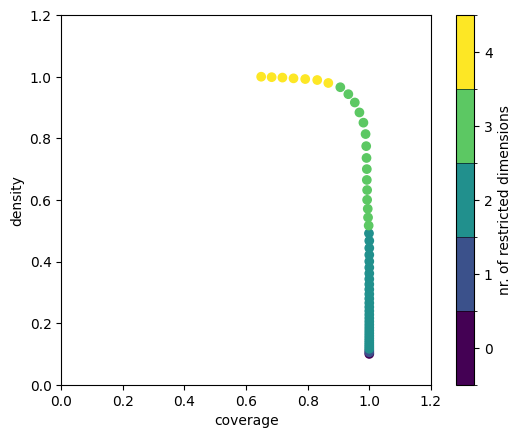

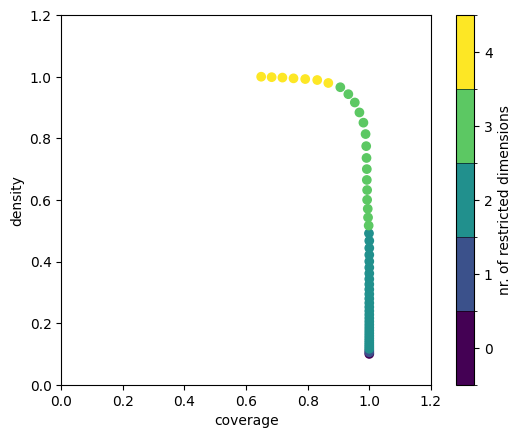

In [12]:
box.show_tradeoff()


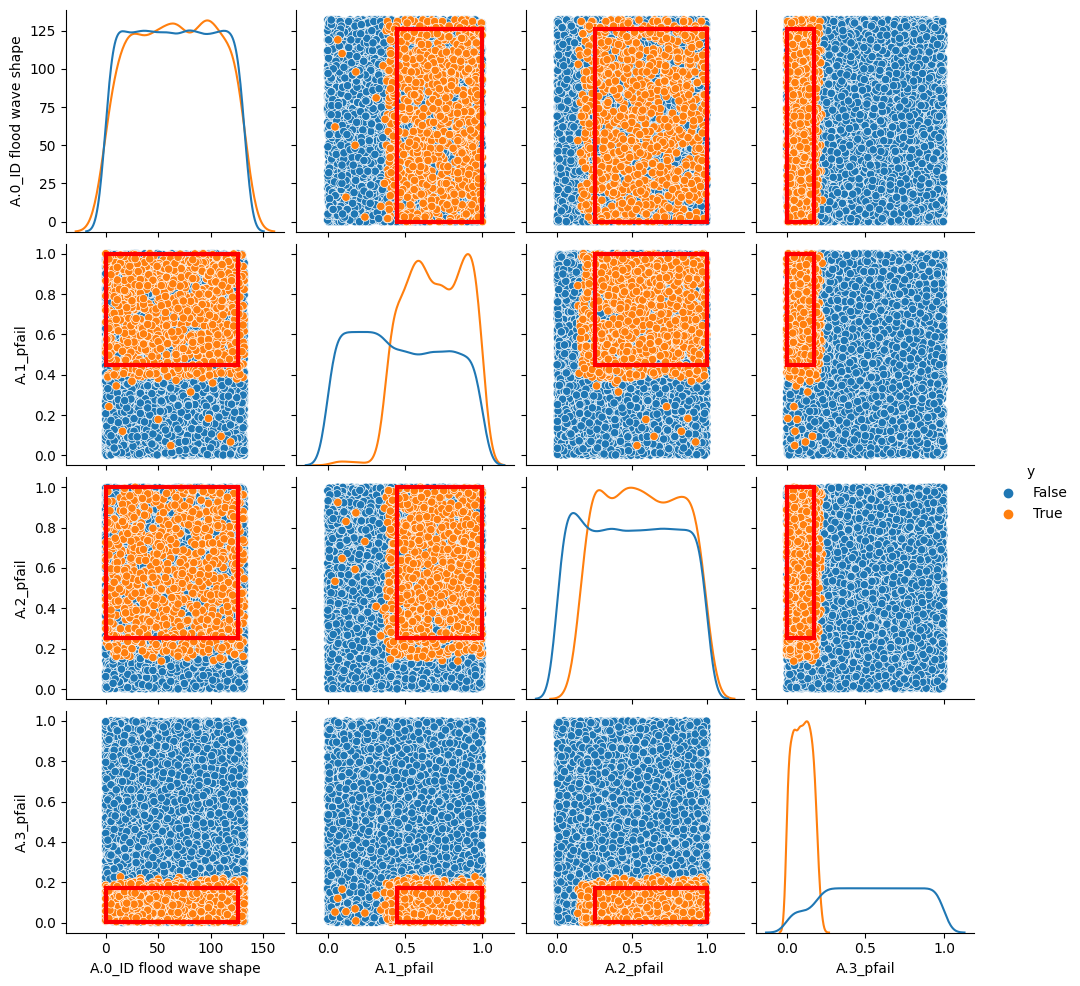

In [13]:
# Show scatter plots for this prim analysis
box.show_pairs_scatter()
plt.show()

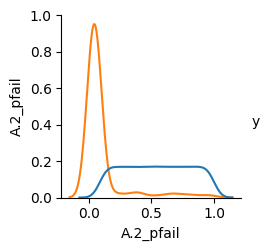

In [14]:
# Show scatter plots for this prim analysis
box1.show_pairs_scatter()
plt.show()

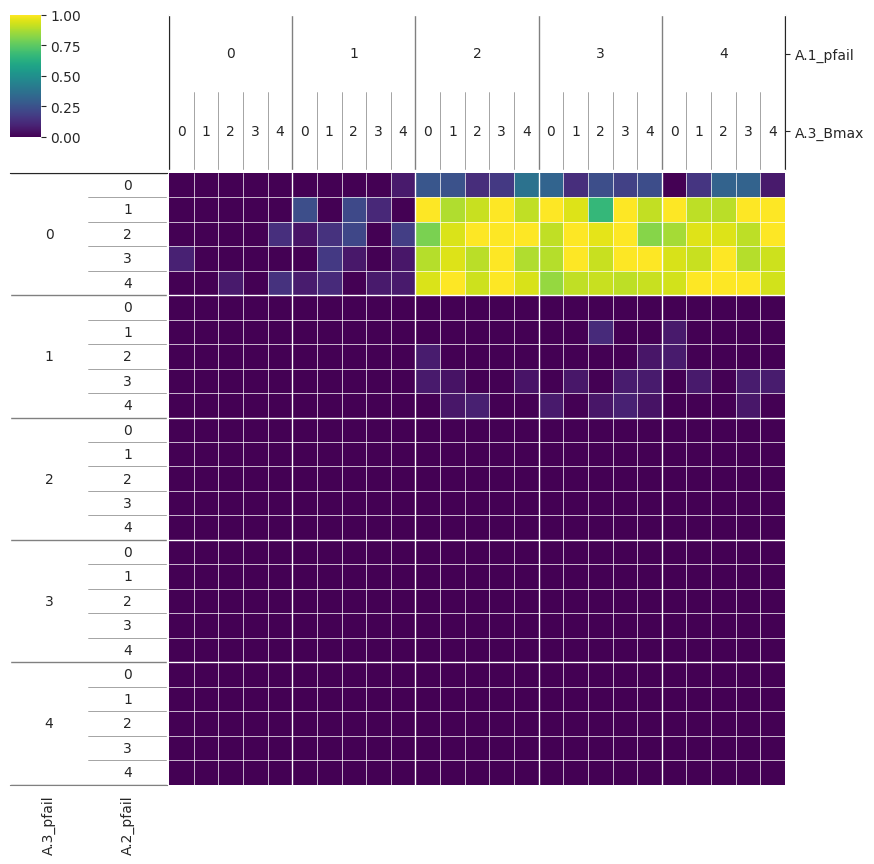

In [15]:
dimensional_stacking.create_pivot_plot(x, y, 2, nbins=5)
plt.show()

In [16]:
# statistical tests and heatmap of p_values
outcomesNull=pd.DataFrame(outcomesNull)
outcomes=pd.DataFrame(outcomes)
# test for normal distribution. If test fails, use non-parametric test of central tendency 
for col in outcomesNull.columns: 
    statistic, p_value = normaltest(outcomesNull[col])
    if p_value >= .05: 
        print(f'normaltest failed for {col} with p={p_value}')
    
for col in outcomes.columns:
    statistic, p_value = normaltest(outcomes[col])
    if p_value >= 0.05:    
        print(f'normaltest failed for {col} with p={p_value}')

In [17]:
print(outcomesNull.columns)
print(outcomes.columns)
print(outcomesNull.shape)
print(outcomes.shape)

Index(['A3 Expected Annual Damage', 'A3 Aggr Expected Number of Deaths',
       'A3 Dike Investment Costs', 'Room for River Investment Costs',
       'Evacuation Costs'],
      dtype='object')
Index(['Expected Annual Damage', 'Total Investment Costs',
       'Expected Number of Deaths'],
      dtype='object')
(10000, 5)
(5000, 3)


In [18]:
# Copy the DataFrame
outcomesNull_transformed = outcomesNull.sample(n=5000, random_state=42)

# Create a new column 'Total Investment Costs' as the sum of 'A3 Dike Investment Costs', 'Room for River Investment Costs', and 'Evacuation Costs'
outcomesNull_transformed['Total Investment Costs'] = outcomesNull_transformed['A3 Dike Investment Costs'] + outcomesNull_transformed['Room for River Investment Costs'] + outcomesNull_transformed['Evacuation Costs']

# Drop the 'A3 Dike Investment Costs', 'Room for River Investment Costs', and 'Evacuation Costs' columns
outcomesNull_transformed = outcomesNull_transformed.drop(['A3 Dike Investment Costs', 'Room for River Investment Costs', 'Evacuation Costs'], axis=1)

# Rename the columns to drop the 'A3' prefix
outcomesNull_transformed = outcomesNull_transformed.rename(columns=lambda x: x.replace('A3 Aggr ', ''))
outcomesNull_transformed = outcomesNull_transformed.rename(columns=lambda x: x.replace('A3 ', ''))

# Now your DataFrame is ready for the t-test
p = pd.DataFrame(columns=outcomesNull_transformed.columns, index=['p_value'])
for col in p.columns: 
    statistic, p_value = ttest_ind(outcomesNull_transformed[col], outcomes[col])
    p[col] = p_value
p


,Expected Annual Damage,Expected Number of Deaths,Total Investment Costs
p_value,2.649881e-174,0.0,0.0


In [19]:
# Set the output to the category that we are interested in for this run
outcome = outcomes['Expected Number of Deaths']

x = experiments
y_limit = np.quantile(outcome, 0.9) # Setting output bound to be 90th percentile 
y = np.array([v > y_limit for v in outcome]) # Only select outputs that are above this threshold

prim_alg = prim.Prim(x, y, threshold=0.8) # run PRIM on bound=0.8
box1 = prim_alg.find_box() # Get the box that prim found for us

[MainProcess/INFO] 5000 points remaining, containing 500 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.0712, coverage: 0.712, density: 1.0 restricted_dimensions: 1


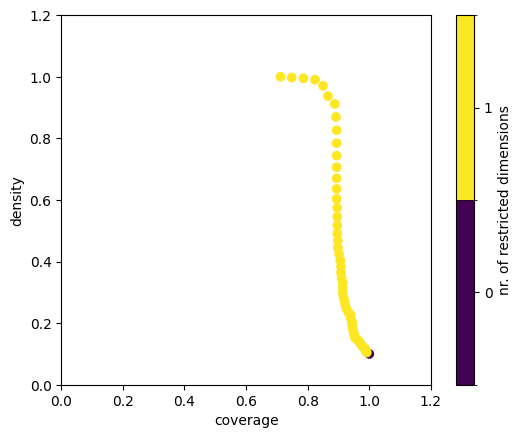

In [20]:
# Show the peeling graph for this prim analysis
box1.show_tradeoff()
plt.show()

In [ ]:
# Define a reference scenario with each uncertainty containing the mean value of its range
scenarios = [Scenario('scenario 1', **{'discount rate 0':3,
                                        'discount rate 1':3,
                                        'discount rate 2':3,
                                        'A.1_Bmax':190,
                                        'A.1_Brate':1.5,
                                        'A.1_pfail':0.5,
                                        'A.2_Bmax':190,
                                        'A.2_Brate':1.5,
                                        'A.2_pfail':0.5,
                                        'A.3_Bmax':190,
                                        'A.3_Brate':1.5,
                                        'A.3_pfail':0.5,
                                        'A.4_Bmax':190,
                                        'A.4_Brate':1.5,
                                        'A.4_pfail':0.5,
                                        'A.5_Bmax':190,
                                        'A.5_Brate':1.5,
                                        'A.5_pfail':0.5,
                                        'A.0_ID flood wave shape':66})
                                    ]

ema_logging.log_to_stderr(ema_logging.INFO)

# Use problem formulation 3 (disaggregated dike rings)
dike_model, planning_steps = get_model_for_problem_formulation(9)


# Perform experiments using SOBOL sampling, in this case used for the levers.
with MultiprocessingEvaluator(dike_model) as evaluator:
    gsa_results = evaluator.perform_experiments(
        scenarios=scenarios, policies=256, lever_sampling=Samplers.SOBOL)


[MainProcess/INFO] pool started with 1 workers
[MainProcess/INFO] performing 1 scenarios * 16384 policies * 1 model(s) = 16384 experiments
  1%|▏                                    | 87/16384 [01:20<3:55:25,  1.15it/s]

In [ ]:
save_results(gsa_results, './results/1scenarios16384policiesPF9SOBOLSample.tar.gz')

In [7]:
load_file_name = './results/1scenarios16384policiesPF9SOBOLSample.tar.gz'
gsa_results = load_results(load_file_name)

[MainProcess/INFO] results loaded successfully from C:\Users\NKondhalkar\Documents\final assignment\results\1scenarios16384policiesPF9SOBOLSample.tar.gz


In [8]:
experiments,outcomes=gsa_results
print(outcomes.keys())

dict_keys(['A3 Expected Annual Damage', 'A3 Aggr Expected Number of Deaths', 'A3 Dike Investment Costs', 'Room for River Investment Costs', 'Evacuation Costs'])


In [12]:
problem = get_SALib_problem(dike_model.levers)

# Using the outputs and samples generated with SOBOL, do the actual global sensitivity analysis (based on variations)
Si = sobol.analyze(problem, outcomes["A3 Expected Annual Damage"], calc_second_order=True)

In [14]:
Si

{'S1': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan]),
 'S1_conf': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan]),
 'ST': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan]),
 'ST_conf': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan]),
 'S2': array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan,

StopIteration: 

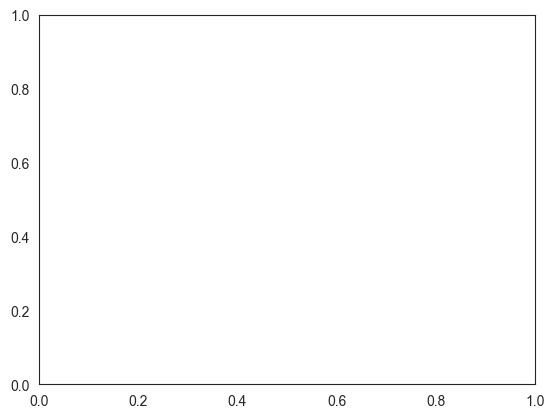

In [13]:

# Plot distributions of ST and ST1 of the values
scores_filtered = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(scores_filtered, index=problem["names"])

sns.set_style("white")
fig, ax = plt.subplots(1)

indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (8,7.5)

# load_file_name = '2000 scenarios 1 policy PF3.tar.gz'
load_file_name = './results/1scenarios16384policiesPF9SOBOLSample.tar.gz'
results = load_results(load_file_name)

experiments, outcomes = results

# Drop levers for other time steps to make graph more compact and readable
experiments.drop(experiments.columns[:19], axis=1, inplace=True)
experiments.drop(columns=["0_RfR 1", "0_RfR 2", "1_RfR 1", "1_RfR 2", "2_RfR 1", "2_RfR 2", "3_RfR 1", "3_RfR 2",
                            "4_RfR 1", "4_RfR 2", "A.1_DikeIncrease 1", "A.1_DikeIncrease 2", "A.2_DikeIncrease 1", "A.2_DikeIncrease 2",
                            "A.3_DikeIncrease 1", "A.3_DikeIncrease 2", "A.4_DikeIncrease 1", "A.4_DikeIncrease 2", "A.5_DikeIncrease 1",
                            "A.5_DikeIncrease 2", "policy"], inplace=True)

x = experiments
y = outcomes

# Get feature scores for the SOBOL sampled inputs and their corresponding outputs
fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="magma", annot=True)
plt.show()